In [1]:
import pandas as pd
import scipy.stats
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pyspark
from pyspark.sql import SparkSession
import os
import math
# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("demoRDD") \
    .config('spark.ui.port', '4058') \
    .getOrCreate()

sc = spark.sparkContext
print(sc)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/07/04 18:00:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/07/04 18:00:08 WARN Utils: Service 'SparkUI' could not bind on port 4058. Attempting port 4059.


<SparkContext master=local[*] appName=demoRDD>


In [3]:
#This is needed to start a Spark session from the notebook
os.environ['PYSPARK_SUBMIT_ARGS'] ="--conf spark.driver.memory=4g  pyspark-shell"

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("Group2") \
    .config('spark.ui.port', '4058') \
    .getOrCreate()

sc = spark.sparkContext
print(sc)

<SparkContext master=local[*] appName=demoRDD>


In [4]:
df_test = pd.read_csv("data/test_final_sessions.csv")
df_test_l = pd.read_csv("data/test_leaderboard_sessions.csv")
df_train_purch = pd.read_csv("data/train_purchases.csv")
df_train_sess = pd.read_csv("data/train_sessions.csv")

canditate_items = pd.read_csv("data/candidate_items.csv")
item_features = pd.read_csv("data/item_features.csv")

In [5]:
df_test

,session_id,item_id,date
0,61,27088,2021-06-01 08:12:39.664
1,96,11693,2021-06-19 17:48:05.227
2,96,18298,2021-06-19 17:49:08.589
3,96,4738,2021-06-19 17:49:15.838
4,96,495,2021-06-19 17:49:20.88
...,...,...,...
226133,4439648,7154,2021-06-14 08:03:19.024
226134,4439675,23067,2021-06-01 12:21:07.959
226135,4439868,26085,2021-06-16 22:18:27.509
226136,4439966,19483,2021-06-06 20:05:06.457


In [6]:
item_features

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


In [7]:
# loading the features data and storing them in an rdd with the structure : 
#('item_id', ('feature_category_id', 'feature_value_id'))

featuresRDD = sc.textFile('data/item_features.csv').map(lambda x: (x.split(',')[0], x.split(',')[1], x.split(',')[2])).filter(lambda x: x[0] != 'item_id')
featuresRDD = featuresRDD.map(lambda x: (int(x[0]), (int(x[1]), int(x[2]))))
featuresRDD.take(3)

[(2, (56, 365)), (2, (62, 801)), (2, (68, 351))]

In [8]:
# item_id are the keys of the pair rdd featuresRDD so with a groupByKey we get an rdd where each line corresponds to a unique item_id
unique_item = featuresRDD.groupByKey()
unique_item.count() 

23691

In [10]:
#x[1][0] represents feature_category_id
feature_count = featuresRDD.map(lambda x: (x[1][0], 1)).reduceByKey(lambda x,y : x+y)
number_of_features = feature_count.count()
print('Number of features : ' +str(number_of_features))

Number of features : 73


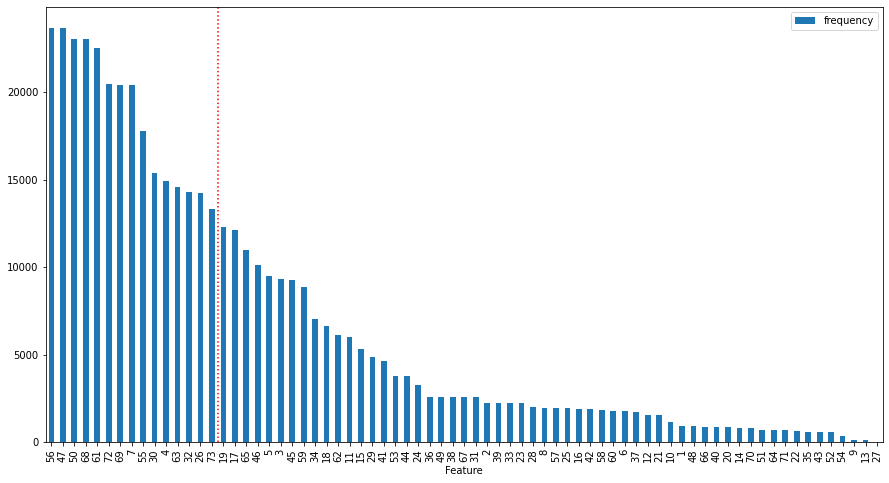

In [13]:
feature_histo = feature_count.sortBy(lambda x: -x[1]).collect()
df = pd.DataFrame(feature_histo, columns=['Feature', 'frequency'])
df.plot(kind='bar', x='Feature',figsize=(15,8))
plt.axvline(x = 14.5, color='r', linestyle='dotted')

In [15]:
feature_count.take(3)

[(56, 23691), (62, 6148), (68, 23038)]

In [16]:
max_items_features = feature_count.map(lambda x: x[1])
n = 13000 #threshold for the number of items for which the feature has a defined value
high_feature_count = feature_count.filter(lambda x : x[1] > n).count()
print(high_feature_count) 
feature_indices = feature_count.filter(lambda x : x[1] > n).map(lambda x: (x[0] - 1)).collect() #the feature_category_id go from 1 to 73 so their indices go from 0 to 72
print(feature_indices)
# Here you must add one to get the real indice in the above histo

15
[55, 67, 71, 49, 31, 3, 25, 29, 60, 6, 68, 46, 72, 54, 62]


## Sessions data

In [17]:
df_train_sess

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186


In [19]:
# The item_id is chosen as the key and (session_id, timestamp) as the value
sessions_RDD = sc.textFile('data/train_sessions.csv') \
    .map(lambda x: (x.split(',')[1], x.split(',')[0], x.split(',')[2])) \
    .filter(lambda x: x[0] != 'item_id') \
    .map(lambda x: (int(x[0]), (int(x[1]), datetime.strptime(x[2][:19], '%Y-%m-%d %H:%M:%S').timestamp(), 0)))
#0 indicates non purchased item
c = sessions_RDD.count()
print('#events = ' + str(c))
sessions_RDD.take(3)

#events = 4743820


[(9655, (3, 1608323100.0, 0)),
 (9655, (3, 1608322788.0, 0)),
 (15654, (13, 1584124527.0, 0))]

In [20]:
#first items
chronological_RDD = sessions_RDD.sortBy(lambda x: x[1][1])
chronological_RDD.take(1)

[(11234, (3747794, 1577833201.0, 0))]

In [21]:
#last items
unchronological_RDD = sessions_RDD.sortBy(lambda x: -x[1][1])
unchronological_RDD.take(1)

[(17618, (3674124, 1622497413.0, 0))]

In [22]:
#first and last and time between the 2
print(datetime.fromtimestamp(1577833201.0))
print(datetime.fromtimestamp(1622497413.0))
print(datetime.fromtimestamp(1622497413.0-1577833201.0)-datetime.fromtimestamp(0))

2020-01-01 00:00:01
2021-05-31 23:43:33
516 days, 22:43:32


In [23]:
# A new key (sess_id, item_id) is created (we want max 1 of each). The reduceByKey groups together the multiple
# occurences of an item in a session. Only the first occurence is kept
unique_sess_item = sessions_RDD.map(lambda x: ((x[0], x[1][0]),(x[1][1],x[1][2]))).reduceByKey(lambda x, y : x+y)
sessions_RDD = unique_sess_item.map(lambda x: (x[0][0], (x[0][1], x[1][0], x[1][1])))

In [26]:
df_train_purch

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114
...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464
999996,4439990,8786,2020-08-22 14:28:22.382
999997,4439994,21630,2020-11-27 20:10:28.961
999998,4439999,16962,2020-11-27 11:01:41.356


In [25]:
P_sessions_RDD = sc.textFile('data/train_purchases.csv') \
    .map(lambda x: (x.split(',')[1], x.split(',')[0], x.split(',')[2])) \
    .filter(lambda x: x[0] != 'item_id') \
    .map(lambda x: (int(x[0]), (int(x[1]), datetime.strptime(x[2][:19], '%Y-%m-%d %H:%M:%S').timestamp(), 1)))

P_sessions_RDD.take(3)

[(15085, (3, 1608323207.0, 1)),
 (18626, (13, 1584124575.0, 1)),
 (24911, (18, 1598462432.0, 1))]

In [28]:
all_sessions_RDD = sessions_RDD.union(P_sessions_RDD)
all_sessions_RDD.take(3)

[(18316, (18, 1598462310.0, 0)),
 (4026, (18, 1598462147.0, 0)),
 (25555, (19, 1604331784.0, 0))]

In [29]:
# we take the last month of the dataset as test set
t_end = datetime.strptime('2021-05-26 00:00:01', '%Y-%m-%d %H:%M:%S').timestamp()
test_sessions_RDD = reduced_sessions_RDD = all_sessions_RDD.filter(lambda x: x[1][1] > t_end)
print('count = ' + str(test_sessions_RDD.count()))
test_sessions_RDD.take(3)

count = 114253


[(19143, (261, 1622460918.0, 0)),
 (11998, (526, 1622183473.0, 0)),
 (5191, (937, 1622032133.0, 0))]

In [30]:
#sample a small part of the dataset to make the computations faster during the coding and debugging phases
reduced_sessions_RDD = all_sessions_RDD.filter(lambda x: x[1][1] < t_end).sample(False, 0.02)
print(reduced_sessions_RDD.count())

100458


In [31]:
#number of purchased items (which is = to the number of sessions) in the reduced dataset
reduced_purchased = reduced_sessions_RDD.filter(lambda x: x[1][2]==1)
reduced_purchased.count()

19819

In [32]:
#number of unique items present in the reduced dataset (out of the ~24,000)
unique_item_list = reduced_sessions_RDD.groupByKey()
unique_item_count = unique_item_list.count()
print(unique_item_count)

15405


## Reshaping the dataset

In [33]:
# verification that no feature can take the value 0
zero_featuresRDD = featuresRDD.filter(lambda x: x[1][1] == 0)
zero_featuresRDD.collect()

[]

In [34]:
featuresRDD.take(3)

[(2, (56, 365)), (2, (62, 801)), (2, (68, 351))]

In [35]:
def sparse_tuple(x):   
    #x = tuple where x[0] is an index and x[1] a value
    #Creates a list (or tuple) with length 73 (72 zeros and x[1] at index x[0])   
    res = [0,]*number_of_features
    res[x[0]-1] = x[1]
    #res = tuple(res)
    print('res : ' + str(res))
    #print(res)
    return res

def add_tuple(x, y, sign):    
    #Addition of tuple (or list) element per element  
    # sign = +1 or -1
    n = len(x)
    if n != len(y):
        raise Exception('x & y of different lengths')
    res = [0]*n
    for i in range(n):
        res[i] = x[i]+ sign * y[i]
    return(tuple(res))

def square_tuple(x):
    res = []
    for i in x:
        res.append(i**2)
    return res

def divide_tuple(vec):
    # a function to divide a input vector into a list of tuples of lengths 2
    res = []
    for i in range(len(vec)//2):
        res.append((vec[2*i], vec[2*i+1]))
    return res

def take_indices(vec, idx):
    # selection of items from a list from a list of indices
    res = []
    for i in idx:
        res.append(vec[i])
    return res

In [37]:
# map the dataset to have on each line 70 items = 0, 1 item with the feature value 
dataset = featuresRDD.map(lambda x : (x[0], sparse_tuple(x[1])))
# reduction to merge all the lines of the same objects, to have one line with the 72 features for each item
dataset = dataset.reduceByKey(lambda x,y : add_tuple(x,y,1)).sortBy(lambda x: x[0]).map(lambda x: (x[0],x[1]))
count = dataset.count()
count

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

res : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 847, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
res : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 108, 0, 0, 0]
res : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 559, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

23691

In [38]:
items_dataset = dataset.map(lambda x: (x[0], take_indices(x[1], feature_indices))) 
items_dataset.take(3)
#now each item is described by a list of 15 features

[(2, [365, 351, 75, 76, 0, 0, 0, 0, 462, 394, 885, 123, 0, 0, 0]),
 (3, [365, 14, 75, 240, 902, 618, 268, 0, 706, 452, 592, 549, 544, 129, 861]),
 (4, [365, 373, 75, 317, 902, 618, 268, 0, 462, 837, 538, 218, 544, 267, 861])]

Sessions

In [39]:
def reorder_tuple(row):
    # input of the function is the RDD which results from the join operation between reduced_session_RDD and items_dataset
    # the structure of the input is a tuple (item_id, ((session_id, timestamp, 0/1),[item features]))
    #the elements are reordered to get an output : (sess_id,(item_id, item_features))
    item_id = row[0]
    sess_id = row[1][0][0]
    timestamp = row[1][0][1]
    item_features = row[1][1] + [timestamp] #the timestamp is added to the features
    return (sess_id,(item_id, item_features))

def separate_lists(x, step):
    # x is a list with the features of all the objects of a session. The function separates this list to get a distinct list
    # for each object
    res = []
    for i in range(len(x) // step):
        res.append(x[step*i:step*(i+1)])
    return res

In [44]:
# join the dataset with the sessions RDD in order to link the information from the 2 RDDs and get an RDD with the features and 
# timestamps of each object in each session
joined_RDD = reduced_sessions_RDD.join(items_dataset).map(lambda x: reorder_tuple(x))
# Reduce the RDD to have a single key for each session
reduced_joined_RDD = joined_RDD.reduceByKey(lambda x, y: x+y )
# Get a list of lists of features for each item
sessions_dataset = reduced_joined_RDD.map(lambda x: (x[0],separate_lists(x[1],2)))
sessions_dataset.take(1)

[(2382540,
  [(18700,
    [365,
     383,
     75,
     240,
     522,
     618,
     44,
     0,
     0,
     798,
     805,
     549,
     544,
     267,
     861,
     1609605665.0])])]

In [45]:
N_sessions = sessions_dataset.count()
print(N_sessions)

92120
